# **Imports**

In [ ]:
# this code is based on https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py, which is released under the BSD-3-Clause License

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# hyperparameters
batch_size  = 64
image_size = 32 # (32 or 64)  
n_channels  = 3

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Data**
We combine both CIFAR10 and STL10 into a single dataset of 32x32 images (or 64x64 images) containing only images of class horse and bird/airplane.



In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# Returns indexes of images belonging to class "label"  
def get_same_index(target, label):
    label_indices = []

    for i in range(len(target)):
        if target[i] == label:
            label_indices.append(i)

    return label_indices


cifar10 = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', download=True, train=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(), torchvision.transforms.Resize(image_size), torchvision.transforms.CenterCrop(image_size), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))

label_class = 7 # horse 
label_class2 = 2 # 0 airplane, 2 bird 

# Get indices of label_class
train_indices = get_same_index(cifar10.targets, label_class)
train_indices2 = get_same_index(cifar10.targets, label_class2)
train_indices2 = train_indices2[:int(len(train_indices2)/3)] # give more weighting to horse class

train_indices = train_indices + train_indices2
cifar10 = torch.utils.data.Subset(cifar10, train_indices) 


stl10 = torchvision.datasets.STL10('drive/My Drive/training/stl10', download=True, split='train', transform=torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(), torchvision.transforms.Resize(image_size), torchvision.transforms.CenterCrop(image_size), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))

label_class = 6 # horse
label_class2 = 1 # 0 airplace, 1 bird

# Get indicies of label_class
train_indices = get_same_index(stl10.labels, label_class)
train_indices2 = get_same_index(stl10.labels, label_class2) 
train_indices2 = train_indices2[:int(len(train_indices2)/3)]

train_indices = train_indices + train_indices2
stl10 = torch.utils.data.Subset(stl10, train_indices) 

# Combine the two datasets into one to train on 
datasets = [cifar10, stl10] 
train_dataset = torch.utils.data.ConcatDataset(datasets) 

# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Our dataloader contains 86 batches of 64 images (5500 images in total)

train_iterator = iter(cycle(dataloader)) 

Files already downloaded and verified
Files already downloaded and verified


# **Viewing training data**

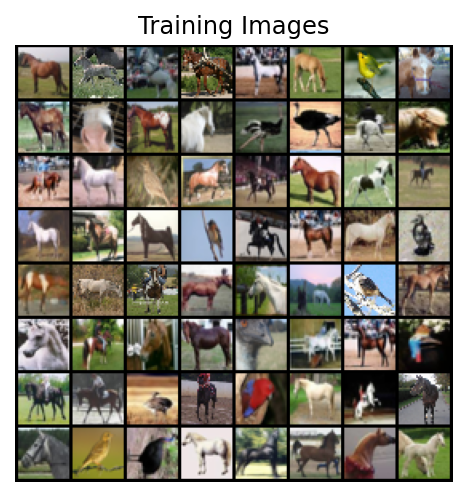

In [ ]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 145
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.axis("off")
plt.title("Training Images")
plt.imshow(torchvision.utils.make_grid(x, normalize=True).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

# **Defining our Generator and Discriminator for the GAN**

This model architecture follows the original DCGAN papers (https://arxiv.org/abs/1511.06434) guidelines for stable Deep Convolutional GANs. The DCGAN paper hardcodes a model for use of 64x64. We remove a layer from both the generator and discriminator when using 32x32 data. 

In [ ]:
# features_d -> channels of discriminator that change

z_dims = 100      # 100-dimensional noise vector 
g_features = 128  # 128 generator
d_features = 128  # 128 discriminator
n_channels = 3    # We want our output to be 32x32x3 (RGB 32x32 images) 


class Generator(nn.Module):
  def __init__(self, z_dims, g_features, n_channels): 
    super(Generator, self).__init__()

    
    # The model follows the same architecture, with one less layer as our input is 32x32 
    self.gen = nn.Sequential(
        
      
        # for 64x64 images
        #nn.ConvTranspose2d(in_channels=z_dims, out_channels=(g_features * 8), kernel_size=4, stride=1, padding=0, bias=False),
        #nn.BatchNorm2d(num_features=(g_features * 8)),
        #nn.ReLU(True),
        
        
        # 100x1x1 -> 512x4x4
        nn.ConvTranspose2d(in_channels=z_dims, out_channels=(g_features * 4), kernel_size=4, stride=1, padding=0, bias=False), # change z_dims to g_features*8 for 64x64
        nn.BatchNorm2d(num_features=(g_features * 4)),
        nn.ReLU(True),

        # 512x4x4 -> 256x8x8
        nn.ConvTranspose2d(in_channels=(g_features * 4), out_channels=(g_features * 2), kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=(g_features * 2)),
        nn.ReLU(True),

        # 256x8x8 -> 128x16x16 
        nn.ConvTranspose2d(in_channels=(g_features * 2), out_channels=(g_features), kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=(g_features)),
        nn.ReLU(True),

        # 128x16x16-> 3x32x32 
        nn.ConvTranspose2d(in_channels=g_features, out_channels=n_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.gen(x)



class Discriminator(nn.Module):
  def __init__(self, d_features, n_channels):
    super(Discriminator, self).__init__()


    self.disc = nn.Sequential(
        
        # 3x32x32 -> 128x16x16
        nn.Conv2d(in_channels=n_channels, out_channels=d_features, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        #nn.Dropout2d(0.25) 

        # 128x16x16 -> 256x8x8
        nn.Conv2d(in_channels=d_features, out_channels=(d_features * 2), kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=(d_features * 2)), 
        nn.LeakyReLU(0.2, inplace=True),
        #nn.Dropout2d(0.25) Reduce mode collapse and increase train stability (https://www.kdd.org/kdd2018/files/deep-learning-day/DLDay18_paper_17.pdf)

        # 256x8x8 -> 512x4x4
        nn.Conv2d(in_channels=(d_features * 2), out_channels=(d_features * 4), kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=(d_features * 4)),
        nn.LeakyReLU(0.2, inplace=True),
        #nn.Dropout2d(0.25) 


        # for 64x64 images
        #nn.Conv2d(in_channels=(d_features * 4), out_channels=(d_features * 8), kernel_size=4, stride=2, padding=1, bias=False),
        #nn.BatchNorm2d(num_features=(d_features * 4)),
        #nn.LeakyReLU(0.2, inplace=True),
        #nn.Dropout2d(0.25) 


        # 512x4x4 -> 1 (binary classification: real/fake) 
        nn.Conv2d(in_channels=(d_features * 4), out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), # change d_features * 8 for 64x64
        nn.Sigmoid()

    )

  def forward(self, x):
    return self.disc(x) 
  

# Initialize weights of model using a random distribution 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G = Generator(z_dims=z_dims, g_features=g_features, n_channels=n_channels).to(device) 
G.apply(weights_init)

D = Discriminator(d_features=d_features, n_channels=n_channels).to(device)
D.apply(weights_init)  


Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [ ]:
lr= 0.0002 # (2e-4)
beta1, beta2 = 0.5, 0.999

# Adam optimizers are known to perform the best for DCGAN
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2)) 
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
bce_loss = nn.BCELoss() 

In [ ]:
# Making sure our generator and discriminator are working properly 

gen_noise = torch.randn(batch_size, 100, 1, 1)
dis_noise = torch.randn(batch_size, 3, image_size, image_size) 
print((G(gen_noise)).shape) # Generator needs to be outputting batch_size * 3x32x32  (64 RGB image_size x image_size images)
print((D(dis_noise)).shape) # Discriminator needs to be outputting batch_size * 1*1*1 (binary classification) 

torch.Size([64, 3, 32, 32])
torch.Size([64, 1, 1, 1])


# **Main training loop**

This training loop is based off the mini-batch stochastic gradient descent algorithm proposed in the original GAN paper (https://arxiv.org/abs/1406.2661)

In [ ]:
PATH = "drive/MyDrive/model-saves/generator.pth" # Path to save model every 10 epochs

epoch = 1
max_epochs = 100
sample_noise = torch.randn(batch_size, 100, 1, 1) # define some sample noise to use when saving images
saved_images = [] # a list containing example batch of generated images each epoch


print("Starting training loop...") 
while epoch < max_epochs+1:

  gen_loss_arr = np.zeros(0) 
  disc_loss_arr = np.zeros(0) 

  # iterate over the train dataset
  for real_data, labels in dataloader: # labels wont be used as it's unsupervised

    real_data = real_data.to(device) # batch_size * image_size x image_size (real images)
    fake_data = G((torch.randn(batch_size, z_dims, 1, 1)).to(device)) # batch_size * image_size x image_size (fake images)

    # Train Discriminator 
    # max logD(x) + log(1-D(G(Z)))
    d_real = D(real_data).reshape(-1) # D(x)
    d_fake = D(fake_data).reshape(-1) # D(G(z))

    loss_d_real = bce_loss(d_real, torch.ones_like(d_real))  #  max logD(x) (represented by min -logD(x) which is equivalent)
    loss_d_fake = bce_loss(d_fake, torch.zeros_like(d_fake)) #  max log(1-D(G(Z))) (represented by min -log(1-D(G(Z))) which is equivalent)
    d_loss = (loss_d_real + loss_d_fake) / 2.0 
    D.zero_grad() 
    d_loss.backward(retain_graph=True) # Don't have to detach fake data 
    D_opt.step() 

    # Train Generator 
    # min log(1-D(G(Z)))
    # To avoid diminishing gradients, train to max logD(G(z)) 
    x = D(fake_data).reshape(-1) # G(z) 
    g_loss = bce_loss(x, torch.ones_like(x)) # logD(G(z)) 
    G.zero_grad() 
    g_loss.backward() 
    G_opt.step() 

    gen_loss_arr = np.append(gen_loss_arr, g_loss.item())
    disc_loss_arr = np.append(disc_loss_arr, d_loss.item())
  

  # Print some statistics each epoch
  print(f"[EPOCH : {epoch}/{max_epochs}]\tGenerator Loss: {gen_loss_arr.mean()}\tDiscriminator Loss: {disc_loss_arr.mean()}")

  if epoch % 10 == 0: # Save our model every 10 epochs 
    torch.save(G.state_dict(), PATH)
    print("Saved model") 


  # Save some examples each epoch (batch of 64 fake images) 
  with torch.no_grad():
    fake_examples = G(sample_noise)
  saved_images.append(torchvision.utils.make_grid(fake_examples, padding=2, normalize=True))
  # Save and store into a folder on drive so we can view results 
  img_name = str(time.gmtime()[3]) + ":" + str(time.gmtime()[4])
  torchvision.utils.save_image(torchvision.utils.make_grid(fake_examples, padding=2, normalize=True), "drive/MyDrive/DCGAN-images/" + f"{img_name}.png")
  print(f"Saved {img_name}.png")

  epoch += 1 

Starting training loop...
[EPOCH : 1/100]	Generator Loss: 4.612920506104179	Discriminator Loss: 0.2958631688485975
Saved model
Saved 18:7.png


KeyboardInterrupt: ignored

In [ ]:
# Collect a batch of 64 fake images from the last epoch  
fake_images = img_list[-1]


# View images generated from the last epoch
plt.rcParams['figure.dpi'] = 145
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_images, (1,2,0)))
plt.show()

In [ ]:
# Save the model so we can reload it from memory 
PATH = "drive/MyDrive/model-saves/generator.pth"
G_save = torch.save(G.save_dict(), PATH)

# Load the model 
# G = Generator().to(device) 
# G.load_state_dict(torch.load(PATH))
# G.eval() 